<a href="https://colab.research.google.com/github/Jeremy26/tracking_course/blob/master/3_YOLO_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Ways to Run YOLO As Fast as Possible

In this workshop, we will learn how to use the YOLO algorithm for object detection

Import the YOLO files and the images

In [ ]:
!wget https://thinkautonomous-tracking.s3.eu-west-3.amazonaws.com/tracking_course.zip && unzip tracking_course.zip

# Tactic 1 — PIP
![](https://www.researchgate.net/profile/Kedar-Potdar-2/publication/329217107/figure/fig4/AS:697578261852162@1543327026650/Object-detection-in-a-dense-scene.ppm)

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import copy

## Read an Image

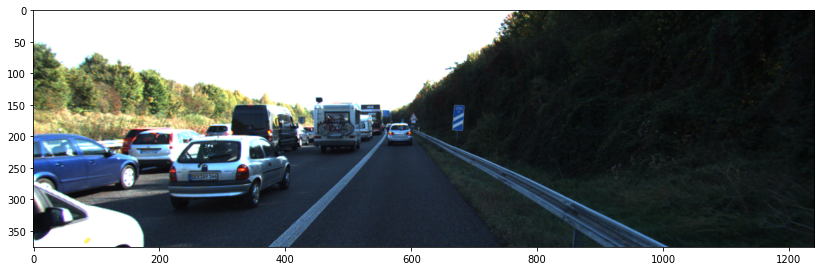

In [3]:
img = cv2.cvtColor(cv2.imread("tracking_course/data/0000000230.png"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14,7))
plt.imshow(img)
plt.show()

## YOLOv5

In [ ]:
!pip install yolo5 # version 0.0.1 used at the moment of recording

In [ ]:
!pip install Pillow==7.1.2

In [6]:
import yolov5

# load model
model = yolov5.load('tracking_course/yolov5s.pt')

In [ ]:
help(model)

In [8]:
model.conf = 0.5
model.iou = 0.4

image = copy.deepcopy(img)
results = model(image)

In [9]:
predictions = results.pred[0]

boxes = predictions[:, :4].tolist()
scores = predictions[:,4].tolist()
categories = predictions[:,5].tolist()

print(boxes)
print(scores)
print(categories)

[[0.0, 192.24169921875, 167.97128295898438, 293.19415283203125], [559.4194946289062, 178.3046875, 602.0789184570312, 212.72305297851562], [212.56971740722656, 195.15029907226562, 408.8998107910156, 318.1595764160156], [133.5529327392578, 185.45498657226562, 265.65155029296875, 260.71484375], [312.91619873046875, 149.4611358642578, 421.98846435546875, 230.4169921875], [442.8334045410156, 143.1591796875, 541.9679565429688, 225.8117218017578], [0.0, 258.53338623046875, 177.9089813232422, 375.3619079589844]]
[0.85888671875, 0.80078125, 0.7880859375, 0.75146484375, 0.6669921875, 0.6474609375, 0.56201171875]
[2.0, 2.0, 2.0, 2.0, 7.0, 7.0, 2.0]


In [10]:
boxes_int = [[int(v) for v in box] for box in boxes]
categories_int = [int(c) for c in categories]

print(boxes_int)
print(scores)
print(categories_int)

[[0, 192, 167, 293], [559, 178, 602, 212], [212, 195, 408, 318], [133, 185, 265, 260], [312, 149, 421, 230], [442, 143, 541, 225], [0, 258, 177, 375]]
[0.85888671875, 0.80078125, 0.7880859375, 0.75146484375, 0.6669921875, 0.6474609375, 0.56201171875]
[2, 2, 2, 2, 7, 7, 2]


In [15]:
def id_to_color(idx):
    """
    Random function to convert an id to a color
    Do what you want here but keep numbers below 255
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

def draw_boxes_v5(image, boxes, categories, mot_mode=False):
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        color = id_to_color(i*10) if mot_mode==True else (255,0,60)
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=3)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return image

In [12]:
classesFile = "tracking_course/coco.names"
with open(classesFile,'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

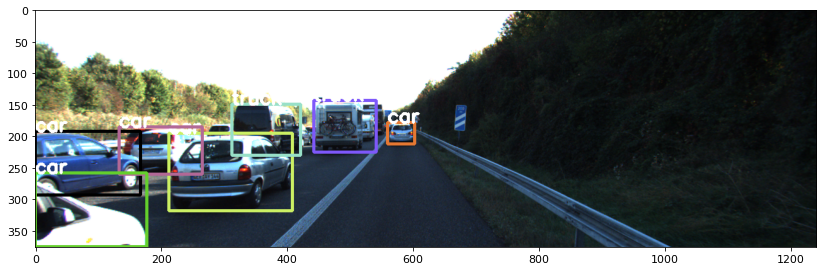

In [14]:
plt.figure(figsize=(14,7))
plt.imshow(draw_boxes_v5(img, boxes, categories,mot_mode=True))
plt.show()

### Create an Inference Function

In [16]:
def inference(img):
    results = model(img)
    predictions = results.pred[0]
    boxes = predictions[:, :4].tolist()
    boxes_int = [[int(v) for v in box] for box in boxes]
    scores = predictions[:,4].tolist()
    categories = predictions[:,5].tolist()
    categories_int = [int(c) for c in categories]
    img_out = draw_boxes_v5(img, boxes_int, categories_int, mot_mode=False)
    return img_out, boxes_int, categories_int, scores

## Run on a Video

In [17]:
import glob 
from tqdm import tqdm

video_images = sorted(glob.glob("tracking_course/data/*.png"))
result_video = []

for img in tqdm(video_images):
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    img_out, _, _, _ = inference(img)
    result_video.append(img_out)

100%|██████████| 837/837 [00:24<00:00, 33.65it/s]


In [18]:
out = cv2.VideoWriter('out_yolo.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (img.shape[1],img.shape[0]))

for img in result_video:
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

# Tactic 2 — OpenCV
![](https://ichi.pro/assets/images/max/724/1*3zUNdMXK_bgwPpBXFb8SfA.jpeg)

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.cfg

In [20]:
cv2.__version__

'4.1.2'

In [ ]:
!pip install opencv-python==4.4.0.46

In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [2]:
cv2.__version__

'4.4.0'

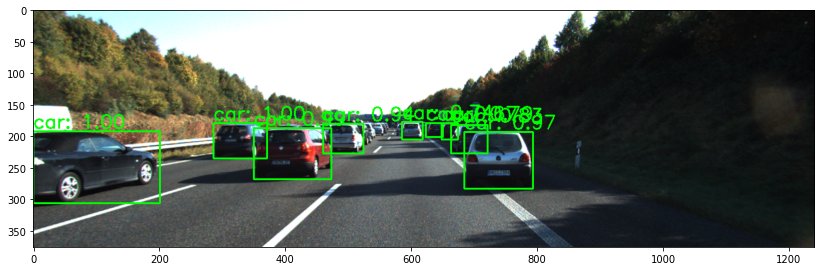

In [3]:
img = cv2.imread('tracking_course/data/0000000000.png')
 
with open('tracking_course/coco.names', 'r') as f:
    classes = f.read().splitlines()
 
net = cv2.dnn.readNetFromDarknet('yolov4.cfg', 'yolov4.weights')

model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)
 
classIds, scores, boxes = model.detect(img, confThreshold=0.5, nmsThreshold=0.4)
 
for (classId, score, box) in zip(classIds, scores, boxes):
    cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]),
                  color=(0, 255, 0), thickness=2)
 
    text = '%s: %.2f' % (classes[classId[0]], score)
    cv2.putText(img, text, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color=(0, 255, 0), thickness=2)

plt.figure(figsize=(14,7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## On a Video

In [4]:
video_images = sorted(glob.glob("tracking_course/data/*.png"))
result_video = []

for img in tqdm(video_images):
    img = cv2.imread(img)
    classIds, scores, boxes = model.detect(img, confThreshold=0.5, nmsThreshold=0.4)
    for (classId, score, box) in zip(classIds, scores, boxes):
        cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]),
                    color=(0, 255, 0), thickness=2)
    
        text = '%s: %.2f' % (classes[classId[0]], score)
        cv2.putText(img, text, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    color=(0, 255, 0), thickness=2)
    result_video.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  6%|▌         | 47/837 [01:05<18:18,  1.39s/it]


KeyboardInterrupt: ignored

In [5]:
out = cv2.VideoWriter('out_yolo_cv.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (img.shape[1],img.shape[0]))

for img in result_video:
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

#Tactic 3 — PyTorch
![](https://github.com/ultralytics/yolov5/releases/download/v1.0/splash.jpg)

In [6]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12495, done.
remote: Total 12495 (delta 0), reused 0 (delta 0), pack-reused 12495
Receiving objects: 100% (12495/12495), 11.60 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (8697/8697), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [8]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

# Images
img = cv2.imread('tracking_course/data/0000000000.png')

# Inference
results = model(img)

# Results
results.save()  # or .show(), .save(), .crop(), .pandas(), etc.

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-4-5 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 
Saved 1 image to runs/detect/exp


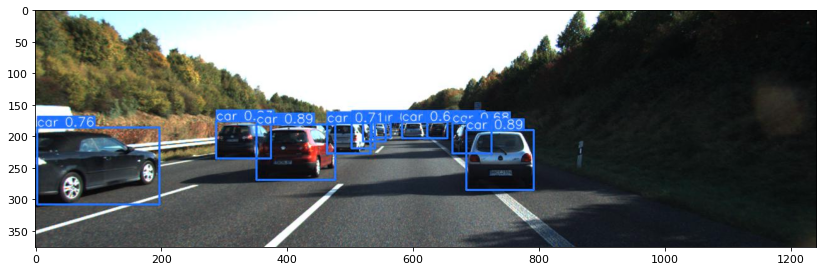

In [9]:
plt.figure(figsize=(14,7))
plt.imshow(cv2.imread("runs/detect/exp/image0.jpg"))
plt.show()

## On a video

In [ ]:
video_images = sorted(glob.glob("tracking_course/data/*.png"))
result_video = []

for img_path in tqdm(video_images):
    img = cv2.imread(img_path)
    results = model(img)
    results.save()

In [11]:
import re

out = cv2.VideoWriter('out_yolo_torch.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (img.shape[1],img.shape[0]))

for img_path in sorted(glob.glob("runs/detect/*/image0.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0])):
    out.write(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
out.release()